This Jupyter notebook validates the quality and privacy of synthetically generated data of Phase 3 of my research by loading pre-trained CTGAN models for different service codes, generating synthetic samples, and evaluating them using utility metrics (Hellinger distance), statistical tests (TSTR - Train on Synthetic, Test on Real), and privacy protection measures (DCR Baseline Protection). 

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sdv.single_table import CTGANSynthesizer
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
from pathlib import Path
from sdv.single_table import CTGANSynthesizer

def unsanitize_filename(name: str) -> str:
    """Reverse the filename sanitization (replace underscores with slashes where needed)."""
    # If underscores are legitimate spaces, only replace those that were originally slashes.
    # Given your naming pattern, just replace the first underscore with a slash if applicable.
    # If more complex, you'll need a mapping file.
    return name.replace("_", "/")

models_dir = Path("checkpoints_4/models")
model_files = list(models_dir.glob("*.pkl"))

print(f"Found {len(model_files)} model files:")
models = {}
service_codes = []

for model_file in model_files:
    # Remove "_final.pkl"
    stem = model_file.stem.replace("_final", "")
    
    # Reverse the earlier sanitization (turn _ back into / in the right places)
    # In your case, original `/` was replaced with `_`
    service_code = stem.replace("_", "/")
    
    print(f"Loading model for: {service_code}")
    model = CTGANSynthesizer.load(str(model_file))
    models[service_code] = model
    service_codes.append(service_code)
    print("✓ Model loaded successfully")

print(f"\n✓ All {len(models)} models loaded successfully!")
print(f"Service codes: {service_codes}")

Found 36 model files:
Loading model for: ASSIST MEMBER OF THE PUBLIC
✓ Model loaded successfully
Loading model for: FALSE CALL
✓ Model loaded successfully
Loading model for: DRUGS/SUBSTANCE MISUSE
✓ Model loaded successfully
Loading model for: TASK INCIDENT
✓ Model loaded successfully
Loading model for: ROAD TRAFFIC OFFENCE
✓ Model loaded successfully
Loading model for: VEHICLE CRIME
✓ Model loaded successfully
Loading model for: PUBLIC NUISANCE
✓ Model loaded successfully
Loading model for: OTHER
✓ Model loaded successfully
Loading model for: ANIMALS
✓ Model loaded successfully
Loading model for: ABANDONED/SILENT 999 CALL
✓ Model loaded successfully
Loading model for: DAMAGE
✓ Model loaded successfully
Loading model for: SUDDEN DEATH
✓ Model loaded successfully
Loading model for: ROAD TRAFFIC MATTER
✓ Model loaded successfully
Loading model for: HOUSEBREAKING
✓ Model loaded successfully
Loading model for: ABANDONED VEHICLES
✓ Model loaded successfully
Loading model for: THEFT
✓ Model 

In [3]:
import pandas as pd

pd.options.display.max_rows = 4000

# Load your filtered dataset from pickle
DATA_PATH = "filtered_data/df_v2_filtered.pkl"

df = pd.read_pickle(DATA_PATH)

import pandas as pd

# Example: assume df is your full incidents DataFrame
cutoff = 5000

# Identify categories below the cutoff
counts = df['service_code_description'].value_counts()
low_categories = counts[counts < cutoff].index

# Replace low-frequency categories with "OTHER"
df['service_code_description'] = df['service_code_description'].replace(low_categories, 'OTHER')

service_code_counts = df["service_code_description"].value_counts()
service_code_counts

service_code_description
ASSIST MEMBER OF THE PUBLIC    169406
CONCERN FOR PERSON             121876
DISTURBANCE                     90395
THEFT                           87517
DOMESTIC INCIDENT               79291
ROAD TRAFFIC MATTER             75033
PUBLIC NUISANCE                 59037
ROAD TRAFFIC COLLISION          58259
OTHER                           44717
ABANDONED/SILENT 999 CALL       41102
EXTERNAL AGENCY REQUEST         40557
ASSAULT                         39608
NOISE                           36849
DAMAGE                          33240
NEIGHBOUR DISPUTE               30507
FALSE CALL                      30413
COMMUNICATIONS                  29706
MISSING PERSON/ABSCONDER        27140
SUSPECT PERSONS                 25141
POLICE INFORMATION              20941
FRAUD INCIDENT                  20360
ROAD TRAFFIC OFFENCE            18563
CHILD PROTECTION                17091
DRUGS/SUBSTANCE MISUSE          16948
VEHICLE CRIME                   15139
DOMESTIC BAIL CHECK      

In [4]:
# Generating slice synthetic data
synthetic_slices = []

# Generating slice synthetic data
for service, count in service_code_counts.items():
    # derive model key from the service description
    model = models.get(service)
    if model is None:
        print(f"Warning: no model for '{service}' (key='{key}'), skipping.")
        continue

    # sample exactly `count` rows
    print(f"Generating {count} samples for '{service}'...")
    slice_df = model.sample(count)

    # tag the synthetic rows with their service code
    slice_df["service_code_description"] = service

    # collect for later concatenation
    synthetic_slices.append(slice_df)

Generating 169406 samples for 'ASSIST MEMBER OF THE PUBLIC'...
Generating 121876 samples for 'CONCERN FOR PERSON'...
Generating 90395 samples for 'DISTURBANCE'...
Generating 87517 samples for 'THEFT'...
Generating 79291 samples for 'DOMESTIC INCIDENT'...
Generating 75033 samples for 'ROAD TRAFFIC MATTER'...
Generating 59037 samples for 'PUBLIC NUISANCE'...
Generating 58259 samples for 'ROAD TRAFFIC COLLISION'...
Generating 44717 samples for 'OTHER'...
Generating 41102 samples for 'ABANDONED/SILENT 999 CALL'...
Generating 40557 samples for 'EXTERNAL AGENCY REQUEST'...
Generating 39608 samples for 'ASSAULT'...
Generating 36849 samples for 'NOISE'...
Generating 33240 samples for 'DAMAGE'...
Generating 30507 samples for 'NEIGHBOUR DISPUTE'...
Generating 30413 samples for 'FALSE CALL'...
Generating 29706 samples for 'COMMUNICATIONS'...
Generating 27140 samples for 'MISSING PERSON/ABSCONDER'...
Generating 25141 samples for 'SUSPECT PERSONS'...
Generating 20941 samples for 'POLICE INFORMATION

In [5]:
synthetic_data = pd.concat(synthetic_slices, ignore_index=True)

## Fidelity

### Hellingers Distance

In [6]:
dft_copy = df.copy()
synthetic_data_copy = synthetic_data.copy()

In [7]:
# Changing datatype from object -> category
object_cols = synthetic_data_copy.select_dtypes(include='object').columns
synthetic_data_copy[object_cols] = synthetic_data_copy[object_cols].astype('category')

In [8]:
## Hellingers Distance
import numpy as np
from collections import Counter

def hellinger_categorical(a, b):
    counter_a = Counter(a)
    counter_b = Counter(b)
    all_keys = set(counter_a) | set(counter_b)
    total_a, total_b = len(a), len(b)
    p = np.array([counter_a.get(k, 0)/total_a for k in all_keys])
    q = np.array([counter_b.get(k, 0)/total_b for k in all_keys])
    return np.linalg.norm(np.sqrt(p) - np.sqrt(q)) / np.sqrt(2)

def hellinger_numerical(a, b, bins=10):
    counts_a, edges = np.histogram(a, bins=bins, density=True)
    counts_b, _ = np.histogram(b, bins=edges, density=True)
    p = counts_a / counts_a.sum()
    q = counts_b / counts_b.sum()
    return np.linalg.norm(np.sqrt(p) - np.sqrt(q)) / np.sqrt(2)

In [9]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

def hellinger(p, q):
    # Normalize to probability distributions
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    p = p / p.sum()
    q = q / q.sum()
    return np.linalg.norm(np.sqrt(p) - np.sqrt(q)) / np.sqrt(2)

def compare_columns(real: pd.DataFrame, synth: pd.DataFrame, bins=10):
    distances = {}
    for col in real.columns:
        if real[col].dtype == 'object' or pd.api.types.is_categorical_dtype(real[col]):
            # Categorical column
            categories = list(set(real[col].unique()) | set(synth[col].unique()))
            real_counts = real[col].value_counts(normalize=True).reindex(categories, fill_value=0)
            synth_counts = synth[col].value_counts(normalize=True).reindex(categories, fill_value=0)
            dist = hellinger(real_counts.values, synth_counts.values)
        else:
            # Numerical column
            col_min = min(real[col].min(), synth[col].min())
            col_max = max(real[col].max(), synth[col].max())
            bin_edges = np.linspace(col_min, col_max, bins + 1)
            real_hist, _ = np.histogram(real[col], bins=bin_edges)
            synth_hist, _ = np.histogram(synth[col], bins=bin_edges)
            dist = hellinger(real_hist, synth_hist)
        distances[col] = dist
    return distances
    
results = compare_columns(dft_copy, synthetic_data_copy, bins=10)

In [10]:
for key,val in results.items():
    print(f"{key}:{val}")

hour_created:0.02901360476338195
max_final_priority:0.03897622527962878
inc_resourced:0.05500667457179958
scrs_crime_inc:0.016086502530068814
service_code_description:0.0
multi_member_ward:0.0414892400320762
date_seq:0.02599367154475108


In [11]:
## Why multivariate hellingers distance is not feasible to caluclate
cols = dft_copy.columns
real_tuples = list(map(tuple, dft_copy[cols].astype(str).values))
synth_tuples = list(map(tuple, synthetic_data_copy[cols].astype(str).values))
# All possible bins encountered in either dataset
all_bins = list(set(real_tuples) | set(synth_tuples))

# number of column combination for evaluating the multivariate distribution
len(all_bins)

2633302

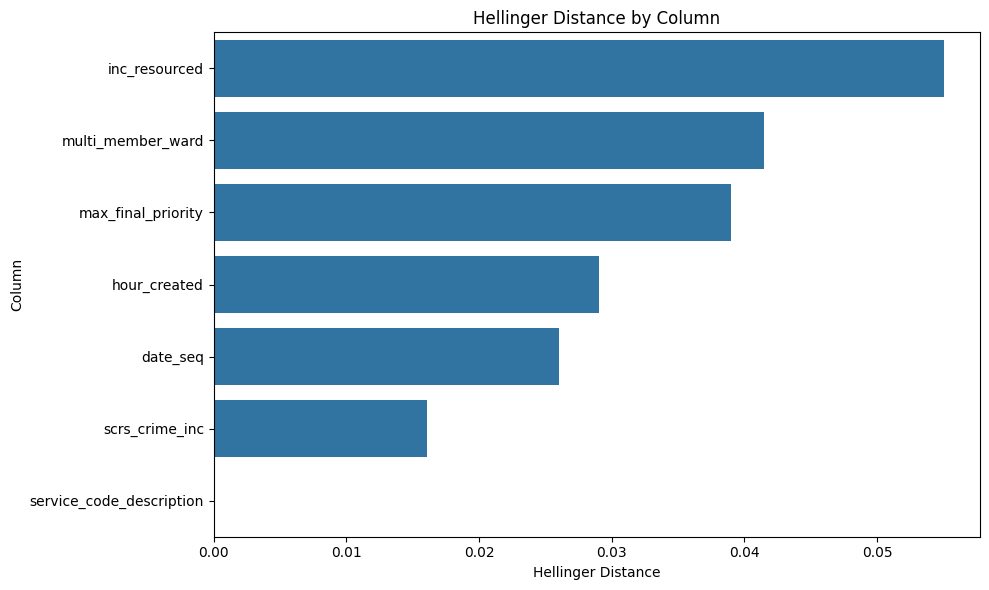

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert results dict to DataFrame
df_dist = (
    pd.DataFrame(results.items(), columns=['column', 'hellinger_distance'])
      .sort_values('hellinger_distance', ascending=False)
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_dist, x='hellinger_distance', y='column')
plt.title('Hellinger Distance by Column')
plt.xlabel('Hellinger Distance')
plt.ylabel('Column')
plt.tight_layout()
plt.show()


### TSTR

In [3]:
# loading data
import pandas as pd

df_filtered = pd.read_pickle("filtered_data/df_v2_filtered.pkl")

In [4]:
from sklearn.model_selection import train_test_split

# Split into 80% train and 20% test
train_df, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

# Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [5]:
total = len(df_filtered)
print("Train set size:", len(train_df), f"({len(train_df)/total:.1%})")
print("Test set size:", len(test_df), f"({len(test_df)/total:.1%})")

Train set size: 1072277 (80.0%)
Test set size: 268070 (20.0%)


In [6]:
from sdv.metadata import Metadata

# 1. auto-detect metadata based in your data
metadata = Metadata.detect_from_dataframes({"incidents":train_df})

# 2. carefully inspect and update your metadata
metadata.visualize()

metadata.validate()

# 3. when you're done, save it to a file for future use
# metadata.save_to_json('my_final_metadata_tstr.json')

In [ ]:
from sdv.single_table import CTGANSynthesizer
ctgan = CTGANSynthesizer(
    metadata,
    epochs=800,
    batch_size=1024,
    pac=8,
    embedding_dim=128,
    generator_dim=(256, 256),
    discriminator_dim=(256, 256),
    generator_lr=2e-4,
    discriminator_lr=2e-4,
    cuda=True,
    verbose=True
)
ctgan.fit(train_df)   

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/single_table/base.py:128: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/single_table/ctgan.py:252: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [ ]:
syn_df = ctgan.sample(len(train_df))

In [ ]:
# Saving the model to a pickle file
ctgan.save(
    filepath='models/ctgan_theft_v8_800epochs_tsrt.pkl'
)

In [ ]:
target_col = 'inc_resourced'                       # ❸ rename to your real target
categorical_cols = [
    col for col in syn_df.columns
    if (syn_df[col].dtype == 'object' or syn_df[col].dtype.name == 'category')
       and col != target_col
]

# Ensure every categorical column is pandas "category" dtype in **both** sets
for col in categorical_cols:
    combined = pd.concat([syn_df[col], test_df[col]], axis=0)
    unified  = pd.Categorical(combined)
    syn_df[col]  = unified[:len(syn_df)].astype('category')
    test_df[col] = unified[len(syn_df):].astype('category')

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    classification_report, confusion_matrix
)

X_syn   = syn_df.drop(columns=[target_col])
y_syn   = syn_df[target_col]

X_test  = test_df.drop(columns=[target_col])
y_test  = test_df[target_col]

lgbm = LGBMClassifier(
    objective='bianary',
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    random_state=42
)

In [ ]:
lgbm.fit(
    X_syn, y_syn,
    categorical_feature=categorical_cols
)

In [ ]:
y_pred       = lgbm.predict(X_test)
y_pred_proba = lgbm.predict_proba(X_test)[:, 1]

print("=== TSTR evaluation (train: synthetic, test: real) ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_pred_proba))
print("F1-score :", f1_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nDetailed report:\n", classification_report(y_test, y_pred))

## Utility

In [13]:
# Creating copies of dfs
dft_copy = df.copy()
synthetic_data_copy = synthetic_data.copy()

dft_copy["is_real"]          = 1        # positive class
synthetic_data_copy["is_real"] = 0        # negative class

full = pd.concat([dft_copy, synthetic_data_copy], ignore_index=True)

In [14]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Assuming 'full' is your combined DataFrame from the prompt

# Define features (X) and target (y)
X = full.drop('is_real', axis=1)
y = full['is_real']

# Convert object columns to the 'category' dtype for LightGBM
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# Split data for training and testing the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train the LightGBM classifier
lgbm = lgb.LGBMClassifier(objective='binary', random_state=42)
lgbm.fit(X_train, y_train)

# Get propensity scores for the entire dataset
# The [:, 1] selects the probability of the positive class (is_real=1)
full['p_score'] = lgbm.predict_proba(X)[:, 1]

# Display the scores for real vs. synthetic data
print(full.groupby('is_real')['p_score'].describe())

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 938243, number of negative: 938242
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 1876485, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000001
[LightGBM] [Info] Start training from score 0.000001
             count      mean       std       min       25%       50%  \
is_real                                                                
0        1340347.0  0.445879  0.147408  0.001671  0.357724  0.46800

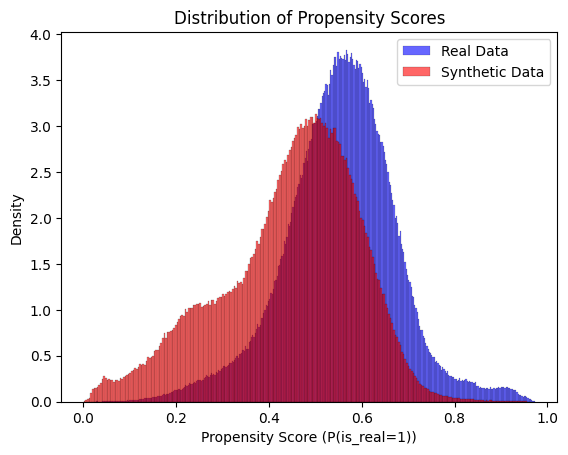

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Separate the scores for real and synthetic data
real_scores = full[full['is_real'] == 1]['p_score']
synthetic_scores = full[full['is_real'] == 0]['p_score']

# Plot the distributions
sns.histplot(real_scores, color="blue", label='Real Data', stat='density', alpha=0.6)
sns.histplot(synthetic_scores, color="red", label='Synthetic Data', stat='density', alpha=0.6)

plt.legend()
plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score (P(is_real=1))')
plt.show()

### Other Metrics

1. Dropped service_code_desc in suspicion that it migh misrepresent
2. Switched to an unbiased MMD² estimator (excluded the diagonal entries for the same reason)

In [46]:
# -----------------------------------------------------------------------
# 0.  Imports
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics.pairwise import pairwise_kernels, pairwise_distances

from scipy.spatial.distance import jensenshannon

from sdmetrics.reports.single_table import QualityReport
from sdv.metadata import SingleTableMetadata

# -----------------------------------------------------------------------
# 1.  Helper: Unbiased Maximum Mean Discrepancy (Gaussian kernel, median heuristic)
# -----------------------------------------------------------------------
def _mmd2_gaussian_unbiased(X, Y, subsample=None):
    """
    Unbiased estimate of MMD² between X and Y with an RBF kernel.
    """
    rng = np.random.default_rng(42)
    if subsample and (len(X) > subsample):
        X = X[rng.choice(len(X), subsample, replace=False)]
    if subsample and (len(Y) > subsample):
        Y = Y[rng.choice(len(Y), subsample, replace=False)]

    # pairwise RBF kernel matrices
    # median heuristic for gamma
    Z = np.vstack([X, Y])
    dists = pairwise_distances(Z, metric='euclidean')
    gamma = 1.0 / (2.0 * np.median(dists[dists > 0]) ** 2)

    Kxx = pairwise_kernels(X, X, metric='rbf', gamma=gamma)
    Kyy = pairwise_kernels(Y, Y, metric='rbf', gamma=gamma)
    Kxy = pairwise_kernels(X, Y, metric='rbf', gamma=gamma)

    n, m = X.shape[0], Y.shape[0]
    sum_Kxx = (Kxx.sum() - np.trace(Kxx)) / (n * (n - 1))
    sum_Kyy = (Kyy.sum() - np.trace(Kyy)) / (m * (m - 1))
    sum_Kxy = Kxy.mean()  # cross terms exclude self-similarities

    return sum_Kxx + sum_Kyy - 2 * sum_Kxy

# -----------------------------------------------------------------------
# 2.  Prepare numeric matrix for MMD (encode categoricals, scale 0-1)
# -----------------------------------------------------------------------
def _prep_for_mmd(df, cat_cols):
    num_cols = [c for c in df.columns if c not in cat_cols]
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df_enc = df.copy()

    if cat_cols:
        df_enc[cat_cols] = enc.fit_transform(df[cat_cols])

    scaler = MinMaxScaler()
    df_enc[num_cols + cat_cols] = scaler.fit_transform(df_enc[num_cols + cat_cols])
    return df_enc[num_cols + cat_cols].to_numpy()

# -----------------------------------------------------------------------
# 3.  Exclude label column from evaluation
# -----------------------------------------------------------------------
label_col = 'service_code_description'
eval_cols = [c for c in df.columns if c != label_col]

# Identify categorical columns within eval_cols
cat_cols = [
    c for c in eval_cols
    if df[c].dtype == 'object' or str(df[c].dtype).startswith('category')
]

# Prepare matrices
X_real  = _prep_for_mmd(df[eval_cols], cat_cols)
X_synth = _prep_for_mmd(synthetic_data[eval_cols], cat_cols)

# Compute unbiased MMD²
mmd2 = _mmd2_gaussian_unbiased(X_real, X_synth, subsample=20000)
print(f"✅  Unbiased MMD² = {mmd2:.6f}   (lower → closer)")

# -----------------------------------------------------------------------
# 4.  Jensen–Shannon divergence – per column, then average (exclude label)
# -----------------------------------------------------------------------
def _js_col(real_col, synth_col, bins=30):
    if pd.api.types.is_numeric_dtype(real_col):
        hist_r, bin_edges = np.histogram(real_col, bins=bins, density=True)
        hist_s, _         = np.histogram(synth_col, bins=bin_edges, density=True)
    else:
        cats    = pd.Series(list(set(real_col) | set(synth_col)))
        hist_r  = real_col.value_counts(normalize=True).reindex(cats, fill_value=0).values
        hist_s  = synth_col.value_counts(normalize=True).reindex(cats, fill_value=0).values
    return jensenshannon(hist_r, hist_s, base=2) ** 2

js_scores = {
    col: _js_col(df[col], synthetic_data[col])
    for col in eval_cols
}
mean_js = np.mean(list(js_scores.values()))
print(f"✅  Jensen–Shannon divergence (mean over columns) = {mean_js:.6f}")

# -----------------------------------------------------------------------
# 5.  SDMetrics QualityReport
# -----------------------------------------------------------------------
# Auto-detect metadata from the real DataFrame
auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df[eval_cols])
metadata_dict = auto_meta.to_dict()

qr = QualityReport()
qr.generate(
    real_data=df[eval_cols],
    synthetic_data=synthetic_data[eval_cols],
    metadata=metadata_dict
)

quality_score = qr.get_score()
print(f"✅  SDMetrics QualityReport overall score = {quality_score:.3f}")

# Optional: per-column shape details
shape_details = qr.get_details(property_name='Column Shapes')
print(shape_details[['Column', 'Metric', 'Score']].head())

✅  Unbiased MMD² = 0.003387   (lower → closer)
✅  Jensen–Shannon divergence (mean over columns) = 0.002279
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 6/6 [00:03<00:00,  1.91it/s]|
Column Shapes Score: 96.32%

(2/2) Evaluating Column Pair Trends: |██████████| 15/15 [00:01<00:00,  9.15it/s]|
Column Pair Trends Score: 92.05%

Overall Score (Average): 94.19%

✅  SDMetrics QualityReport overall score = 0.942
               Column        Metric     Score
0        hour_created  KSComplement  0.981737
1  max_final_priority  TVComplement  0.946221
2       inc_resourced  TVComplement  0.937276
3      scrs_crime_inc  TVComplement  0.979837
4   multi_member_ward  TVComplement  0.955791


## Heat Map

In [16]:
# loading lookup file
lookup = pd.read_csv('DataZone2011lookup_2024-12-16.csv', encoding='latin1')
import unicodedata

# Function to normalize multi_member_ward values
def normalize_ward_name(name):
    if pd.isnull(name):
        return name
    name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("utf-8")
    name = name.replace("&", "and").replace("/", ",").replace("'", "").strip()
    name = ' '.join(name.split())  # remove extra internal spaces
    return name.lower()  # optional: lowercase for consistency

# Apply to real dataset before training
lookup["MMWard_Name"] = lookup["MMWard_Name"].map(normalize_ward_name)

✅ All observed wards are in lookup
✅ All synthetic wards are in lookup


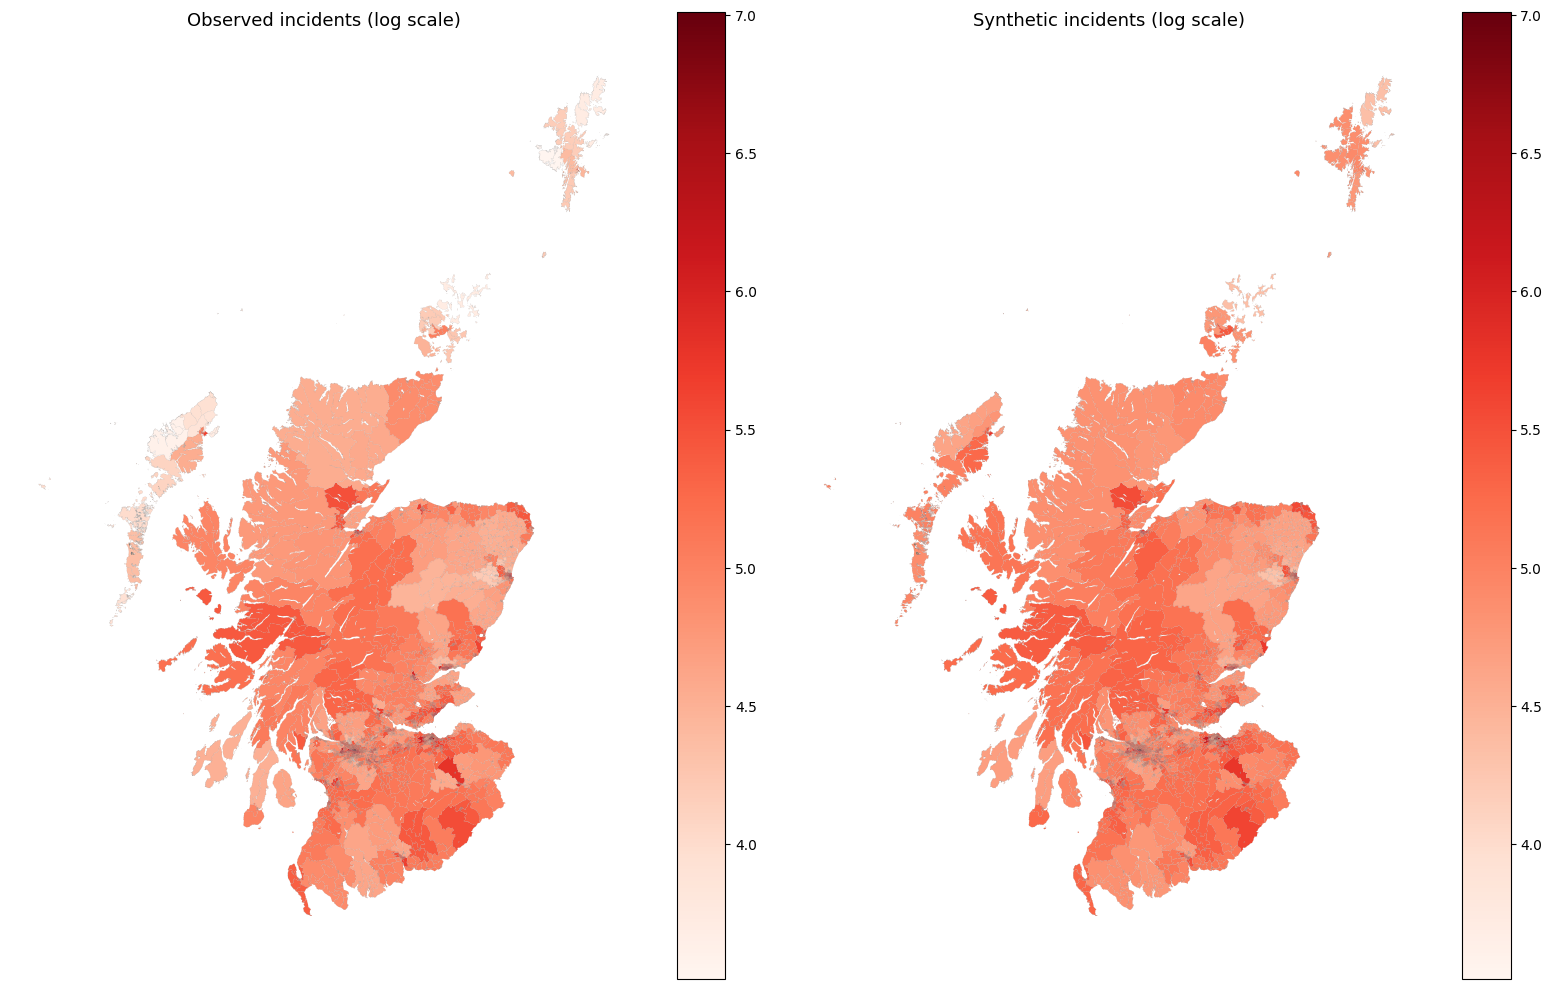

In [18]:
# ───────────────────────────  0.  HOUSEKEEPING  ───────────────────────────
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# If your lookup hasn’t been renamed yet, do it once:
lookup = (lookup
          .rename(columns={"DZ2011_Code": "DataZone"})  # <-- change only if needed
          [["DataZone", "MMWard_Name"]])                # keep essentials

# ───────────────────────────  0.1  CHECK FOR UNMAPPED WARDS  ───────────────────────────
lookup_wards = set(lookup["MMWard_Name"].unique())

obs_unique = set(df["multi_member_ward"].dropna().unique())
syn_unique = set(synthetic_data["multi_member_ward"].dropna().unique())

obs_missing = obs_unique - lookup_wards
syn_missing = syn_unique - lookup_wards

if obs_missing:
    print(f"⚠️ Observed wards not in lookup ({len(obs_missing)}): {sorted(obs_missing)[:10]}{'...' if len(obs_missing) > 10 else ''}")
else:
    print("✅ All observed wards are in lookup")

if syn_missing:
    print(f"⚠️ Synthetic wards not in lookup ({len(syn_missing)}): {sorted(syn_missing)[:10]}{'...' if len(syn_missing) > 10 else ''}")
else:
    print("✅ All synthetic wards are in lookup")

# ───────────────────────────  1.  WARD-LEVEL COUNTS  ───────────────────────────
for frame in (df, synthetic_data):
    frame["incident_count"] = 1  # one incident per row

obs_ward = (df
            .groupby("multi_member_ward", as_index=False)["incident_count"]
            .sum()
            .rename(columns={"multi_member_ward": "MMWard_Name",
                             "incident_count": "ward_incidents"}))

syn_ward = (synthetic_data
            .groupby("multi_member_ward", as_index=False)["incident_count"]
            .sum()
            .rename(columns={"multi_member_ward": "MMWard_Name",
                             "incident_count": "ward_incidents"}))

# ───────────────────────────  2.  EXPAND TO DATA-ZONE  ───────────────────────────
dz_per_ward = (lookup
               .groupby("MMWard_Name")
               .size()
               .rename("n_dz")
               .reset_index())

def expand_to_dz(ward_counts: pd.DataFrame) -> pd.DataFrame:
    out = (ward_counts
           .merge(lookup, on="MMWard_Name", how="left")  # duplicate per DZ
           .merge(dz_per_ward, on="MMWard_Name", how="left"))
    out["dz_incidents"] = out["ward_incidents"] / out["n_dz"]  # uniform share
    return out[["DataZone", "dz_incidents"]]

obs_dz = expand_to_dz(obs_ward)
syn_dz = expand_to_dz(syn_ward)

# ───────────────────────────  3.  LOAD & RENAME SHAPEFILE  ───────────────────────────
shp_path = "shape_files/SG_DataZone_Bdry_2011.shp"

shp = (gpd.read_file(shp_path)
       .rename(columns={"DZ_CODE": "DataZone"})  # CHANGE 'DZ_CODE' if needed
       .to_crs(epsg=4326))

# ───────────────────────────  4.  JOIN COUNTS → POLYGONS  ───────────────────────────
def attach_counts(gdf_base: gpd.GeoDataFrame,
                  dz_counts: pd.DataFrame) -> gpd.GeoDataFrame:
    gdf = (gdf_base.merge(dz_counts, on="DataZone", how="left")
                    .fillna({"dz_incidents": 0}))
    gdf["log_inc"] = np.log1p(gdf["dz_incidents"])  # log(x+1)
    return gdf

gdf_obs = attach_counts(shp, obs_dz)
gdf_syn = attach_counts(shp, syn_dz)

# Compute shared limits on the plotted variable (log_inc)
vmin = min(gdf_obs["log_inc"].min(), gdf_syn["log_inc"].min())
vmax = max(gdf_obs["log_inc"].max(), gdf_syn["log_inc"].max())

from matplotlib.colors import Normalize
norm = Normalize(vmin=vmin, vmax=vmax)

# ───────────────────────────  5.  PLOT SIDE-BY-SIDE  ───────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharex=True, sharey=True)

for ax, gdf_map, title in [
        (axes[0], gdf_obs, "Observed incidents (log scale)"),
        (axes[1], gdf_syn, "Synthetic incidents (log scale)")]:
    gdf_map.plot(
        column="log_inc",
        ax=ax,
        cmap="Reds",
        legend=True,
        edgecolor="grey",
        linewidth=0.05,
        norm=norm,           # <- shared scale
    )
    ax.set_title(title, fontsize=13)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Privacy

In [62]:
from sdmetrics.single_table import DCRBaselineProtection

table_name = "incidents"
auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df)
metadata_dict = auto_meta.to_dict()

score = DCRBaselineProtection.compute_breakdown(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=metadata_dict,
    num_rows_subsample=20000,    # Subsample to 20,000 rows for computation speed
    num_iterations=5             # Run 5 iterations and average for stability
)

score

{'score': 0.776710915888368,
 'median_DCR_to_real_data': {'synthetic_data': 0.12530622513031422,
  'random_data_baseline': 0.16133086957534518}}

In [10]:
from sdmetrics.single_table import DCRBaselineProtection
from sdv.metadata import SingleTableMetadata

table_name = "incidents"
auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df)
metadata_dict = auto_meta.to_dict()

score = DCRBaselineProtection.compute_breakdown(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=metadata_dict,
    num_rows_subsample=20000,    # Subsample to 20,000 rows for computation speed
    num_iterations=5             # Run 5 iterations and average for stability
)

score

{'score': 0.7786207848747445,
 'median_DCR_to_real_data': {'synthetic_data': 0.14317179905415012,
  'random_data_baseline': 0.18388168602485777}}

In [6]:
from sdmetrics.single_table import DCRBaselineProtection
from sdv.metadata import SingleTableMetadata

table_name = "incidents"
auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df)
metadata_dict = auto_meta.to_dict()

score = DCRBaselineProtection.compute_breakdown(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=metadata_dict,
    num_rows_subsample=100000,    # Subsample to 20,000 rows for computation speed
    num_iterations=3           # Run 5 iterations and average for stability
)

score

{'score': np.float64(0.2483429407092307),
 'median_DCR_to_real_data': {'synthetic_data': np.float64(0.0400893546651265),
  'random_data_baseline': np.float64(0.16142748440885088)}}